In [1]:
# Cost-Sensitive Decision Tree Implemetation with Prepruning 
# Author: Ayhan Okuyan
# Last Modified: Nov 2020

# Note: To run this implementation, all the dependencies and graph must be installed.
# For MacOS versions, graphviz can be installed using homebrew: 'brew install graphviz'
# For other OS versions, check https://graphviz.org/download/

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from graphviz import Digraph
import matplotlib.colors as colors
import matplotlib.cm as cm


In [2]:
#load train_data
#set current working directory
cwd = os.getcwd()
#load train data as csv
train_data = pd.read_csv(os.path.join(cwd, 'train_data.txt'), sep=' ', header=None)
train_data.reset_index(drop=True, inplace=True)
train_data = train_data.to_numpy()[:,:-2]

#load test data as csv
test_data = pd.read_csv(os.path.join(cwd, 'test_data.txt'), sep=' ', header=None)
test_data.reset_index(drop=True, inplace=True)
test_data = test_data.to_numpy()[:,:-2]

#convert to features and labels
print(train_data.shape)
print(test_data.shape)

numFeatures = train_data.shape[1]
train_features = train_data[:,:numFeatures-1]
train_labels = train_data[:,numFeatures-1]
test_features = test_data[:,:numFeatures-1]
test_labels = test_data[:,numFeatures-1]

print(train_features.shape)
print(train_labels.shape)

(3772, 22)
(3428, 22)
(3772, 21)
(3772,)


In [3]:
#load feature names 
costMatrix = pd.read_csv(os.path.join(cwd, 'thy_cost.txt'), sep=':', header=None)
costMatrix.head()
#featNames = np.append(featNames, '-')

costVector = list(costMatrix.to_numpy()[:,1])
print(costVector)
featNames = costMatrix.to_numpy()[:,0]
featNames = np.append(featNames, 'extracted')
print(featNames)
featNames = np.append(featNames,'pure')

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 22.78, 11.41, 14.51, 11.41]
['age' 'sex' 'on_thyroxine' 'query_on_thyroxine'
 'on_antithyroid_medication' 'sick' 'pregnant' 'thyroid_surgery'
 'I131_treatment' 'query_hypothyroid' 'query_hyperthyroid' 'lithium'
 'goitre' 'tumor' 'hypopituitary' 'psych' 'TSH' 'T3' 'TT4' 'T4U'
 'extracted']


In [4]:
# redesign cost vector such that the last element (extracted) holds the indices of the extracted features
costVector.append([18,19])
print(costVector)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 22.78, 11.41, 14.51, 11.41, [18, 19]]


In [5]:
def gini(nodeLabels):
    labels, counts = np.unique(nodeLabels, return_counts=True)
    gini = 0
    all_counts = np.sum(counts)
    for i in range(len(labels)):
        gini += (counts[i]/all_counts)**2 
    gini_imp = (1 - gini)
    return gini_imp   

def entropy(nodeLabels):
    labels, counts = np.unique(nodeLabels, return_counts=True)
    entropy = 0
    all_counts = np.sum(counts)
    for i in range(len(labels)):
        entropy -= (counts[i]/all_counts)*np.log2(counts[i]/all_counts)
    return entropy   

def calcImpurity(nodeLabels, impurity):
    if(impurity == 'gini'):
        return gini(nodeLabels)
    elif(impurity == 'entropy'):
        return entropy(nodeLabels)
    else:
        raise Exception("Invalid choice of Impurity: " + impurity[0])
        
def calcSplitImpurity(feature, labels, val, impurity):
    left_split = labels[feature <= val]
    p_left = len(left_split)/len(labels)
    right_split = labels[feature > val]
    return p_left * calcImpurity(left_split, impurity) + (1-p_left) * calcImpurity(right_split, impurity)

def calcInfoGain(feature, labels, val):
    entropy = calcImpurity(labels, 'entropy')
    split_entropy = calcSplitImpurity(feature, labels, val, 'entropy')
    return entropy - split_entropy

# Expected in the form ['nunez', 'w', 'cost'] or ['tan', 'cost'] or ['linear', alpha]
# Since we take the minimum of criterion, we take the negative of the criterion described in slides
def costSensitiveSplit(feature, labels, val, choice):
    infoGain = calcInfoGain(feature, labels, val)
    if choice[0] == 'nunez':
        return -(2**(infoGain-1))/((choice[2]+1)**choice[1])
    elif choice[0] == 'tan':
        return -infoGain**2/choice[1]
    elif choice[0] == 'linear':
        return -(infoGain + choice[1]*choice[2])
    else:
        raise Exception("Invalid choice of Cost-Sensitive Split Criterion: " + str(choice)) 

def isPaid(node, indices):
    paidCost = [1] * len(indices)
    temp = node
    
    while temp.parent is not None:
        if(temp.split_index in indices):
            paidCost[indices.index(temp.split_index)] = 0
        temp = temp.parent
    if(temp.split_index in indices):
        paidCost[indices.index(temp.split_index)] = 0
    return paidCost

def changeCostVector(node, costVector):
    newCosts = np.copy(costVector)
    temp = node
    while temp.parent is not None:
        if(type(costVector[temp.split_index]) is not list):
            newCosts[temp.split_index] = 0.0
        else:
            compList = costVector[temp.split_index]
            for comp in compList:
                newCosts[comp] = 0.0
            newCosts[temp.split_index] = 0.0
        temp = temp.parent
    if(type(costVector[temp.split_index]) is not list):
        newCosts[temp.split_index] = 0.0
    else:
        compList = costVector[temp.split_index]
        for comp in compList:
            newCosts[comp] = 0.0
            newCosts[temp.split_index] = 0.0
    return newCosts
    

def calcExtractedCost(node, indices, costVector):
    costMultiplier = np.asarray(isPaid(node, indices))
    cost = np.sum(costMultiplier * [costVector[i] for i in indices])
    return cost, costMultiplier

def alterCostVector(node, costVector):
    alteredCosts = np.copy(costVector)
    for i,costElement in enumerate(costVector):
        if type(costElement) is list:
            #change the cost of the extracted cost which is originally as list of the mixed featurs
            cost, costMult = calcExtractedCost(node, costElement, costVector)
            alteredCosts[i] = cost
    return alteredCosts

def splittingCriterion(feature, labels, val, choice):
    if len(choice) == 1:
        return calcSplitImpurity(feature, labels, val, choice[0])
    else: 
        return costSensitiveSplit(feature, labels, val, choice)
        

def bestSplitofFeature(feature, labels, choice):
    bestSplitCrit = np.inf
    threshold = np.inf
    infGain = -1
    for i,val in enumerate(feature):
        splitCrit = splittingCriterion(feature, labels, val, choice)
        if(splitCrit <= bestSplitCrit):
            bestSplitCrit = splitCrit;
            threshold = val 
            infGain = calcInfoGain(feature, labels, val)
    return bestSplitCrit, threshold, infGain

def bestSplit(features, labels, choice, costVector):
    featureIndex = 21
    bestSplitCrit = np.inf
    threshold = np.inf
    best_gain = -1
    cost = 0

    for i in range(features.shape[1]):
        
        feature_oi = features[:,i]
        
        if len(costVector) > 0: 
            choiceTemp = list.copy(choice)
            choiceTemp.append(costVector[i])
            splitCrit, thr, gain = bestSplitofFeature(feature_oi, labels, choiceTemp)
        else:
            splitCrit, thr, gain = bestSplitofFeature(feature_oi, labels, choice)
        
        
        if(splitCrit <= bestSplitCrit):
            bestSplitCrit = splitCrit
            featureIndex = i
            threshold = thr
            best_gain = gain
            cost = costVector[i]
            
    
    left_features = features[features[:,featureIndex] <= threshold]
    left_labels = labels[features[:,featureIndex] <= threshold]
    
    right_features = features[features[:,featureIndex] > threshold]
    right_labels = labels[features[:,featureIndex] > threshold]
    
    return threshold, featureIndex, best_gain, bestSplitCrit, cost, left_features, left_labels, right_features, right_labels

class Node():
    def __init__(self, depth, parent):
        #for if not pure -> -1, else label 
        self.leaf_label = -1
        #parent link and children links
        self.parent = parent
        self.children = []
        #feature of split and split value
        self.split = 0.5
        self.split_index = 20
        # impurity or split criterion value
        self.split_crit = 0.0
        #depth of node
        self.depth = depth   
        # for plottling, each node is given an id
        self.id = 0
        # record split and classes to plot the tree like sklearn
        self.numSamples = 0
        self.labels = []
        self.label_counts = []
        # hold the cost to further calculate average cost
        self.cost = 0.0
        
    def formatLabel(self):
        formattedStr = '['
        for lb,ct in zip(self.labels, self.label_counts):
            formattedStr += str(int(lb)) + ': ' + str(ct) + ', '
        formattedStr = formattedStr[:-2] + ']'
        return formattedStr
    
def createTree(node, features, labels, choice, prun, costVector): 
    #find (label, count) pairs to plot
    node.numSamples = len(labels)
    lbs,cts = np.unique(labels, return_counts = True)
    node.labels = lbs
    node.label_counts = cts
        
    # is pure
    if(np.min(labels) == np.max(labels)):
        lbs, cts = np.unique(labels, return_counts=True)
        node.leaf_label = lbs[np.argmax(cts)]
        return      
    # prepruning for depth
    elif(prun[0] == 'depth' and node.depth == prun[1]):
        lbs, cts = np.unique(labels, return_counts=True)
        node.leaf_label = lbs[np.argmax(cts)]
        return
    else:
        if(len(costVector) > 0):
            alteredCostVector = alterCostVector(node, costVector)
            split_val, split_feat_index, infGain, split_crit, cost, left_features, left_labels, right_features, right_labels = \
            bestSplit(features, labels, choice, alteredCostVector)
        else:
            split_val, split_feat_index, infGain, split_crit, cost, left_features, left_labels, right_features, right_labels = \
            bestSplit(features, labels, choice, costVector)
        
        #print(featNames[split_feat_index])
        
        #prepruning for information gain
        if(prun[0] == 'gain' and infGain <= prun[1]):
            lbs, cts = np.unique(labels, return_counts=True)
            node.leaf_label = lbs[np.argmax(cts)]
            return
        
        node.split_crit = split_crit
        
        node.split = split_val
        node.split_index = split_feat_index
        
        node.cost = cost
        #set the cost of all the features extracted in earlies steps to zero                
        costVector = changeCostVector(node, costVector)
                
        left_child = Node(node.depth+1, node)
        right_child = Node(node.depth+1, node)
        node.children.append(left_child)
        node.children.append(right_child)
        createTree(left_child, left_features, left_labels, choice, prun, costVector)
        createTree(right_child, right_features, right_labels, choice, prun, costVector)

def predictSample(node, inp):
    if(node.leaf_label != -1):
        return node.leaf_label
    else:
        if(inp[node.split_index] <= node.split):
            pred = predictSample(node.children[0], inp)
        else:
            pred = predictSample(node.children[1], inp)
        return pred
    
def generateColorPalette(num, cmap):
    colormap = cm.get_cmap(cmap, num)
    newcolors = colormap(np.linspace(0, 1, num))
    return newcolors

def getColor(palette, ind):
    color = palette[ind,:]
    rgb = str(colors.to_hex(color))
    if (color[0]*0.299 + color[1]*0.587 + color[2]*0.114) > (186/256):
        textColor = '#000000' 
    else:
        textColor = '#ffffff'
    return (rgb, textColor)

def accumulateCost(node, inp, cost=0):
    if(node.leaf_label != -1):
        return cost
    else:
        if(inp[node.split_index] <= node.split):            
            cost += node.cost
            return cost + accumulateCost(node.children[0], inp)
        else:
            cost += node.cost
            return cost + accumulateCost(node.children[1], inp)
        

class TreeClassifier():
    def __init__(self):
        self.tree = None
        self.choice = ['gini']
        self.prun = ['none']
        self.costVector = []
        
    def train(self, features, labels, choice=['gini'], prun=['none'], costVector=[]):
        if(choice[0] == 'tan' or choice[0] == 'nunez' or choice[0] == 'linear') and not costVector:
            costVector = [1] * features.shape[1]
        elif(choice[0] == 'gini' or choice[0] == 'entropy') and costVector != []:
            costVector = []
            
        self.choice = choice
        self.prun = prun
        self.costVector = costVector

        root = Node(0, None)
        createTree(root, features, labels, choice, prun, costVector)
        self.tree = root
    def predict(self, inp):
        if self.tree != None:
            res = []
            for i in range(inp.shape[0]):
                res.append(predictSample(self.tree, inp[i,:]))
            return np.asarray(res)
        else:
            print('Can\'t predict before training')
            return -1
            
    def traintestresults(self, train_features, train_labels, test_features, test_labels):
        #TRAINING ACCURACIES
        train_pred = self.predict(train_features)
        #print(train_pred.shape, train_pred.min(), train_pred.max())
        print('Training Accuracy: %.3f%%' % (np.sum(train_pred==train_labels)
              /train_pred.shape[0]*100))
        numSamples = np.zeros(3)
        truePreds =  np.zeros(3)
        for sample, result in zip(train_labels, train_pred):
            numSamples[int(result)-1] += 1
            if(sample == result):
                truePreds[int(result)-1] += 1
        classAccs = truePreds/numSamples*100
        print('Class-Based Accuracies:')
        for i in range(3):
            print('Accuracy of Class %d: %.3f%%' % (i+1,classAccs[i]))
        cm = confusion_matrix(train_labels, train_pred, labels=[1,2,3])
        cm_display = ConfusionMatrixDisplay(cm, display_labels=[1,2,3]).plot()
        plt.title('Confusion Matrix for Training Data')
        plt.show()

        #TEST ACCURACIES
        test_pred = self.predict(test_features)
        #print(test_pred.shape, test_pred.min(), test_pred.max())
        print('Test Accuracy: %.3f%%' % (np.sum(test_pred==test_labels)
              /test_pred.shape[0]*100))
        numSamples = np.zeros(3)
        truePreds =  np.zeros(3)
        for sample, result in zip(test_labels, test_pred):
            numSamples[int(result)-1] += 1
            if(sample == result):
                truePreds[int(result)-1] += 1
        classAccs = truePreds/numSamples*100
        print('Class-Based Accuracies:')
        for i in range(3):
            print('Accuracy of Class %d: %.3f%%' % (i+1,classAccs[i]))

        cm = confusion_matrix(test_labels, test_pred, labels=[1,2,3])
        cm_display = ConfusionMatrixDisplay(cm, display_labels=[1,2,3]).plot()
        plt.title('Confusion Matrix for Test Data')
        plt.show()

    def plotTree(self, names, precision=3, cmap='RdBu', save=False, filename='tree', format='png'):
        if(self.tree == None):
            print("Train to show tree")
            return
        
        palette = generateColorPalette(len(names)+1, cmap)
        
        univ_id = 0
        g = Digraph(name = 'tree', filename = filename, format=format, 
                    graph_attr = {'ranksep': 'equally'},
                    node_attr={'shape': 'rectangle', 'fontname': 'helvetica', 'fontsize':'10', 'dpi':'300',
                              'margin': '0.03,0.03'})

        current_level = [self.tree]
        
        #prep_label
        label = names[self.tree.split_index] + '<=' + str(round(self.tree.split, precision)) + '\n'
        label += self.getChoiceString() + '=' + str(abs(round(self.tree.split_crit,precision))) + '\n'
        label += 'samples: ' + str(self.tree.numSamples) + '\n'
        label += 'value: ' + self.tree.formatLabel()
        
        #Assign 1 to root node
        colors = getColor(palette, self.tree.split_index)
        g.node("node_1", label= label, style='filled',fillcolor=colors[0], fontColor=colors[1])
        while current_level:
            for node in current_level:
                univ_id += 1
                node.id = univ_id 
                if node.parent != None:
                    if node.leaf_label != -1:
                        label = 'majority class: ' + str(int(node.leaf_label)) + '\n'
                        label += 'samples: ' + str(node.numSamples) + '\n'
                        label += 'value: ' + node.formatLabel()
                    else:  
                        label = names[node.split_index] + '<=' + str(round(node.split, precision)) + '\n'
                        label += self.getChoiceString() + '=' + str(abs(round(node.split_crit, precision))) + '\n'
                        label += 'samples: ' + str(node.numSamples) + '\n'
                        label += 'value: ' + node.formatLabel()
                    
                    colors = getColor(palette,node.split_index)
                    g.node("node_" + str(node.id), label=label, style='filled',fillcolor=colors[0], fontcolor=colors[1])
                    g.edge("node_" + str(node.parent.id), "node_" + str(node.id))

            next_level = list()
            for node in current_level:
                if node.leaf_label == -1:
                    next_level.append(node.children[0])
                    next_level.append(node.children[1])
            current_level = next_level
        if(save):
            g.view()
        return g
    
    def getChoiceString(self):
        if self.choice[0] == 'nunez':
            return self.choice[0] + ' (w=%.2f)' % self.choice[1]
        elif self.choice[0] == 'linear':
            return self.choice[0] + ' (a=%.2f)' % self.choice[1]
        else:
            return self.choice[0]
        
    def extractCost(self, inp):
        costs = []
        for i in range(inp.shape[0]):
            costs.append(accumulateCost(self.tree, inp[i,:]))
        return np.asarray(costs)

Training Accuracy: 99.814%
Class-Based Accuracies:
Accuracy of Class 1: 94.898%
Accuracy of Class 2: 98.964%
Accuracy of Class 3: 100.000%


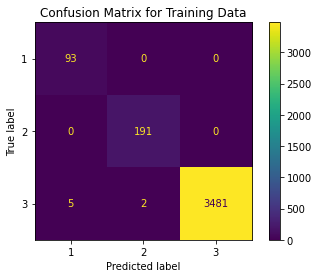

Test Accuracy: 99.329%
Class-Based Accuracies:
Accuracy of Class 1: 86.905%
Accuracy of Class 2: 94.118%
Accuracy of Class 3: 99.968%


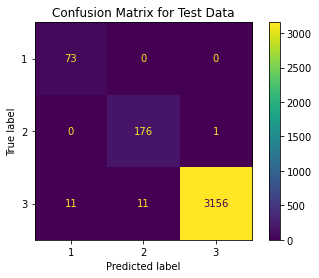

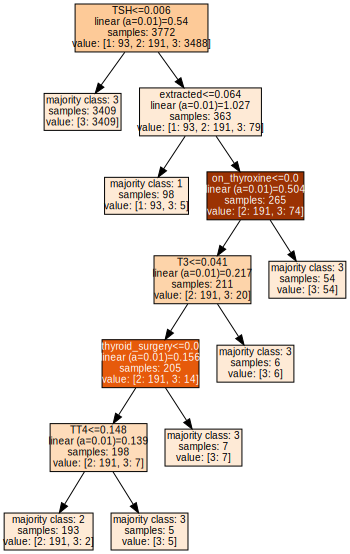

In [10]:
tree = TreeClassifier()
tree.train(train_features, train_labels, choice=['linear', 0.01], prun=['gain', 0.1], costVector=costVector)
tree.traintestresults(train_features, train_labels, test_features, test_labels)
tree.plotTree(featNames, cmap='Oranges_r', save=True, filename='images/part3/linear_0.01_gain_0.074')

In [11]:
testCosts = tree.extractCost(test_features)
for i in range(1,4):
    print('Average Cost of Class %d: %.2f' % (i, np.mean(testCosts[np.asarray(test_labels) == i])))

Average Cost of Class 1: 48.70
Average Cost of Class 2: 62.11
Average Cost of Class 3: 23.72


Training Accuracy: 99.788%
Class-Based Accuracies:
Accuracy of Class 1: 94.898%
Accuracy of Class 2: 98.454%
Accuracy of Class 3: 100.000%


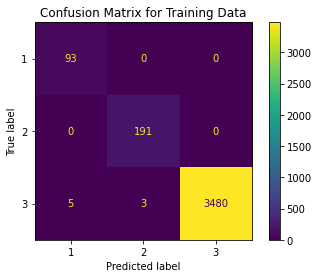

Test Accuracy: 99.329%
Class-Based Accuracies:
Accuracy of Class 1: 86.905%
Accuracy of Class 2: 94.118%
Accuracy of Class 3: 99.968%


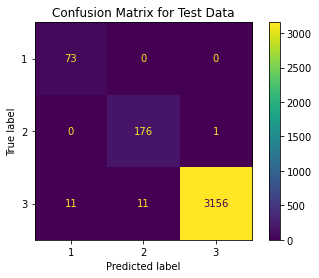

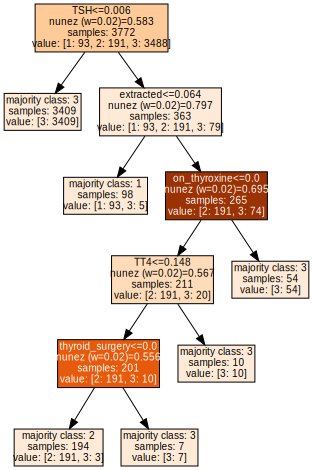

In [8]:
tree = TreeClassifier() #0.02, 0.1
tree.train(train_features, train_labels, choice=['nunez', 0.02], prun=['gain', 0.1], costVector=costVector)
tree.traintestresults(train_features, train_labels, test_features, test_labels)
tree.plotTree(featNames, cmap='Oranges_r', save=True, filename='images/part3/nunez_0.02_gain_0.1')

In [9]:
testCosts = tree.extractCost(test_features)
for i in range(1,4):
    print('Average Cost of Class %d: %.2f' % (i, np.mean(testCosts[np.asarray(test_labels) == i])))

Average Cost of Class 1: 48.70
Average Cost of Class 2: 50.69
Average Cost of Class 3: 23.61
